### NLP - Análise de Sentimentos em Pesquisas de Satisfação
### MBA em Ciência de Dados (Cemeai/USP)

#### Autora: Thalita Cristina de Souza
#### Orientador: Prof. Dr. Julio Cezar Estrella
##### Última atualização: Dezembro/2020

### Configurações iniciais

In [1]:
# Configuração do valor da semente para garantir a reprodução dos mesmos resultados
seed_value = 1313

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
# Importando as bibliotecas

# Bibliotecas de manipulação e visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

# Pré-processamento dos elementos textuais
import texthero as hero
from texthero import preprocessing, stopwords, nlp
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PortugueseStemmer

# Modelagem NLP
#from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, PCA
import spacy
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
import pt_core_news_sm
nlp = pt_core_news_sm.load()

# Algoritmos clássicos de classificação
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Modelo ensemble de classificação
import lightgbm as lgb

# Tensorflow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing as keras_prep
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import initializers
from tensorflow.keras.layers import GRU, LSTM, Dense, RNN, SimpleRNN, Flatten, Embedding, Dropout, GlobalAveragePooling1D, LeakyReLU
from tensorflow.random import set_seed

# Métricas
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.pipeline import make_pipeline 
from scipy.stats import ttest_ind, shapiro, levene
import baycomp

# Validação Cruzada
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold

# modelo treinado da NLTK para segmentação de sentença
stok = nltk.data.load('tokenizers/punkt/portuguese.pickle')

In [3]:
print("Versões das principais bibliotecas utilizadas")
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Tensorflow: ", tf.__version__)
print("Keras: ", keras.__version__)
print("TensorflowHub version: ", hub.__version__)
print("LightGBM: ", lgb.__version__)
print("NLTK: ", nltk.__version__)
print("Spacy: ", spacy.__version__)
print("Seaborn: ", sns.__version__)

Versões das principais bibliotecas utilizadas
Pandas:  1.1.2
Numpy:  1.18.5
Tensorflow:  2.3.1
Keras:  2.4.0
TensorflowHub version:  0.10.0
LightGBM:  3.0.0
NLTK:  3.5
Spacy:  2.3.2
Seaborn:  0.11.0


In [4]:
# Lista completa dos pacotes e biliotecas utilizados no ambiente
!pip list

Package                  Version
------------------------ ---------------------
absl-py                  0.10.0
argon2-cffi              20.1.0
astor                    0.8.1
astroid                  2.3.3
astunparse               1.6.3
async-generator          1.10
attrs                    20.2.0
autograd                 1.3
autograd-gamma           0.4.2
backcall                 0.2.0
baycomp                  1.0.2
bleach                   3.1.5
blis                     0.4.1
boto3                    1.15.11
botocore                 1.18.11
cachetools               4.1.1
catalogue                1.0.0
certifi                  2020.6.20
cffi                     1.14.2
chardet                  3.0.4
click                    7.1.2
cloudpickle              1.3.0
colorama                 0.4.3
cycler                   0.10.0
cymem                    2.0.3
Cython                   0.29.14
dataclasses              0.7
DateTime                 4.3
decorator                4.4.2
defusedxml   

In [5]:
# Exibindo a versão do Python nesse ambiente
from platform import python_version
print (python_version())

3.6.11


### Upload do dataset

In [6]:
# Upload do dataset de treino
df = pd.read_csv('dataset_nlp.csv', encoding='latin-1')
print("Tamanho do dataset:", df.shape)
df.head()

Tamanho do dataset: (1613, 2)


,sentence,class
0,Informações,positiva
1,Dar sugestões de melhorias para os novos colab...,positiva
2,mais informações para a SAL e CAL,positiva
3,Análise e relatório de cursos realizados na UV...,positiva
4,Está ótimo,positiva


In [7]:
# Elimininando valores nulos e exibindo infos do dataset
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 0 to 1612
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1611 non-null   object
 1   class     1611 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB


In [8]:
# Criando o dataset que será processado e utilizado no treino
df_prep = df.copy()
df_prep.head()

,sentence,class
0,Informações,positiva
1,Dar sugestões de melhorias para os novos colab...,positiva
2,mais informações para a SAL e CAL,positiva
3,Análise e relatório de cursos realizados na UV...,positiva
4,Está ótimo,positiva


### Análise exploratória

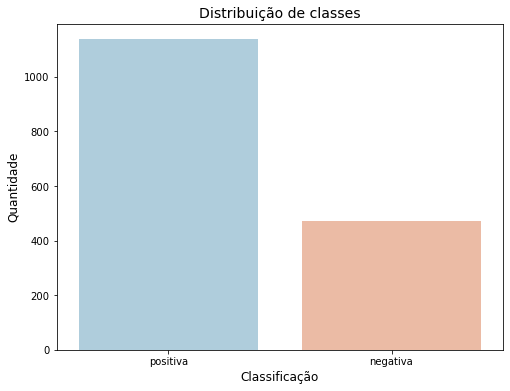

In [9]:
# Plot da distribuição das classes
plt.figure(figsize=(8,6))
sns.countplot(x='class',data=df, palette='RdBu_r')
plt.title('Distribuição de classes', fontsize=14)
plt.xlabel("Classificação", fontsize=12)
plt.ylabel("Quantidade", fontsize=12);

In [10]:
# Percentual das classes
positive = df['class'][df['class']=='positiva'].count()/len(df['class'])
print('Percentual da classe positiva: %0.3f' % positive)

negative = df['class'][df['class']=='negativa'].count()/len(df['class'])
print('Percentual da classe negativa: %0.3f' % negative)

Percentual da classe positiva: 0.706
Percentual da classe negativa: 0.294


In [11]:
# Contagem de palavras
df['count_words'] = df['sentence'].apply(lambda x:len(x.split(" ")))

# Contagem de letras
df['count_letters'] = df['sentence'].apply(lambda x:len(x))

# Exibindo a soma de palavras e letras
print('Quantidade total de palavras:', df['count_words'].sum())
print('Quantidade total de letras:', df['count_letters'].sum())

Quantidade total de palavras: 16676
Quantidade total de letras: 95768


In [12]:
# Exibindo as estatísticas da coluna de contagem de palavras
df['count_words'].describe()

count    1611.000000
mean       10.351335
std        10.252621
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        71.000000
Name: count_words, dtype: float64

In [13]:
# Exibindo a mediana da coluna de contagem de palavras
df['count_words'].median()

7.0

In [14]:
# Exibindo o tamanho da maior e menor sentença
longest = df_prep.sentence.str.len().max()
shortest = df_prep.sentence.str.len().min()
print("Tamanho da maior sentença:", longest)
print("Tamanho da menor sentença:", shortest)

Tamanho da maior sentença: 411
Tamanho da menor sentença: 1


c:\users\2104411064\anaconda3\envs\ad_env_v2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



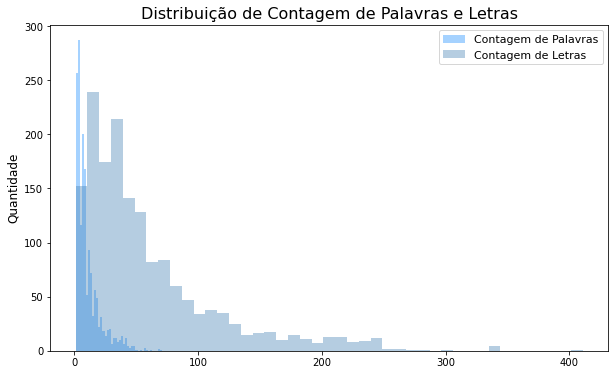

In [15]:
# Histograma de frequência de quantidade de palavras
plt.subplots(figsize=(10,6))
sns.distplot(df.count_words, color="dodgerblue", label="Contagem de Palavras", kde=False)
sns.distplot(df.count_letters, color="steelblue", label="Contagem de Letras", kde=False)

plt.title("Distribuição de Contagem de Palavras e Letras", fontsize=16)
plt.xlabel("     ", fontsize=12)
plt.ylabel("Quantidade", fontsize=12)
plt.legend(fontsize=11);

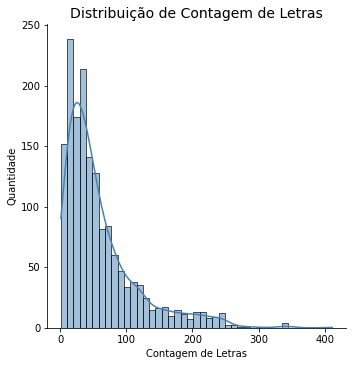

In [16]:
# Fistograma de frequência de quantidade de letras
sns.displot(df.count_letters, color="steelblue", label="Contagem de Letras", kde=True)
plt.title("Distribuição de Contagem de Letras", fontsize=14)
plt.xlabel("Contagem de Letras")
plt.ylabel("Quantidade");

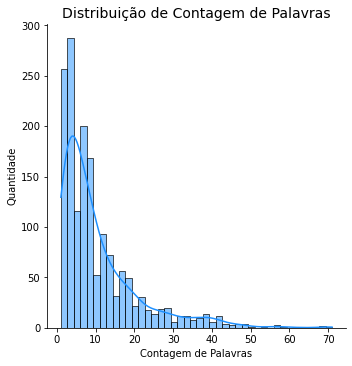

In [17]:
# Histograma de frequência de quantidade de palavras
sns.displot(df.count_words, color="dodgerblue", label="Contagem de Palavras", kde=True)
plt.title("Distribuição de Contagem de Palavras", fontsize=14)
plt.xlabel("Contagem de Palavras")
plt.ylabel("Quantidade");

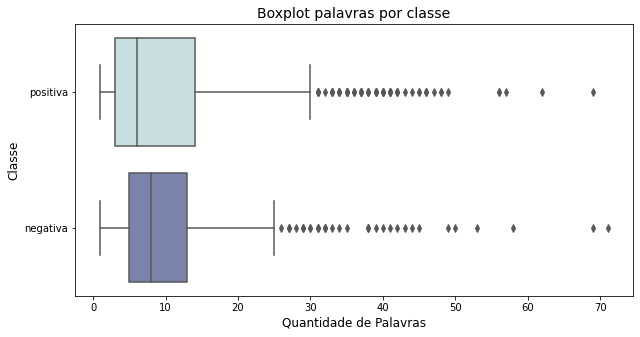

In [18]:
# Exibindo o boxplot de palavras por classe
plt.figure(figsize=(10,5))
plt.title("Boxplot palavras por classe", fontsize=14)
sns.boxplot(y="class", x="count_words", data = df, orient="h", palette = 'ch:6.5,-.4,dark=.5')
plt.xlabel("Quantidade de Palavras", fontsize=12)
plt.ylabel("Classe", fontsize=12);

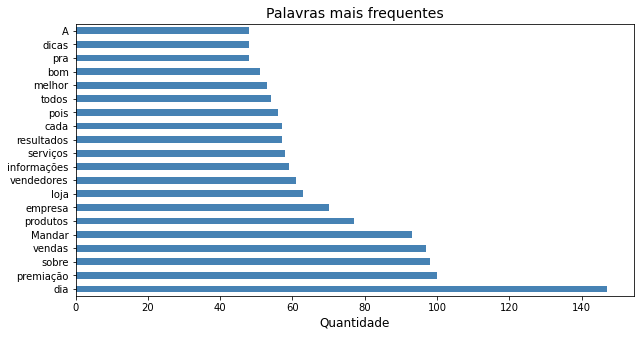

In [19]:
# Aplicando stop words e exibindo as palavras mais frequentes
stop_words = nltk.corpus.stopwords.words('portuguese')
df['clean'] = hero.remove_stopwords(df_prep['sentence'], stop_words)

freq_words = hero.top_words(df['clean'], normalize=False)[:20]

plt.figure(figsize=(10,5))
plt.title("Palavras mais frequentes", fontsize=14)
freq_words.plot(kind='barh', color='steelblue')
plt.xlabel("Quantidade", fontsize=12);
plt.show()

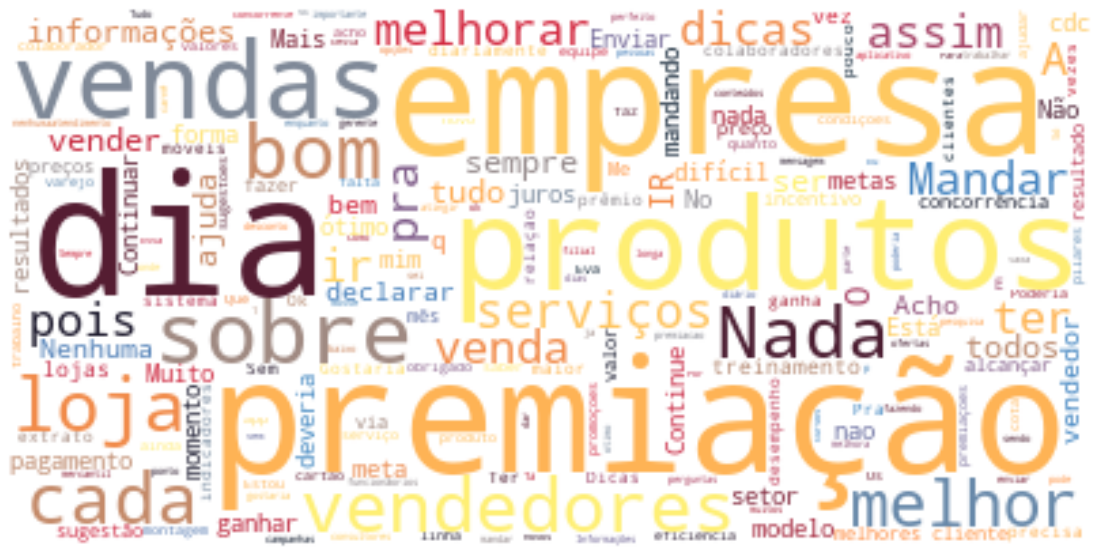

In [20]:
# Exibindo principais palavras relacionadas à classe positiva
hero.visualization.wordcloud(df[df['class'] == 'positiva']['clean'], background_color='white')

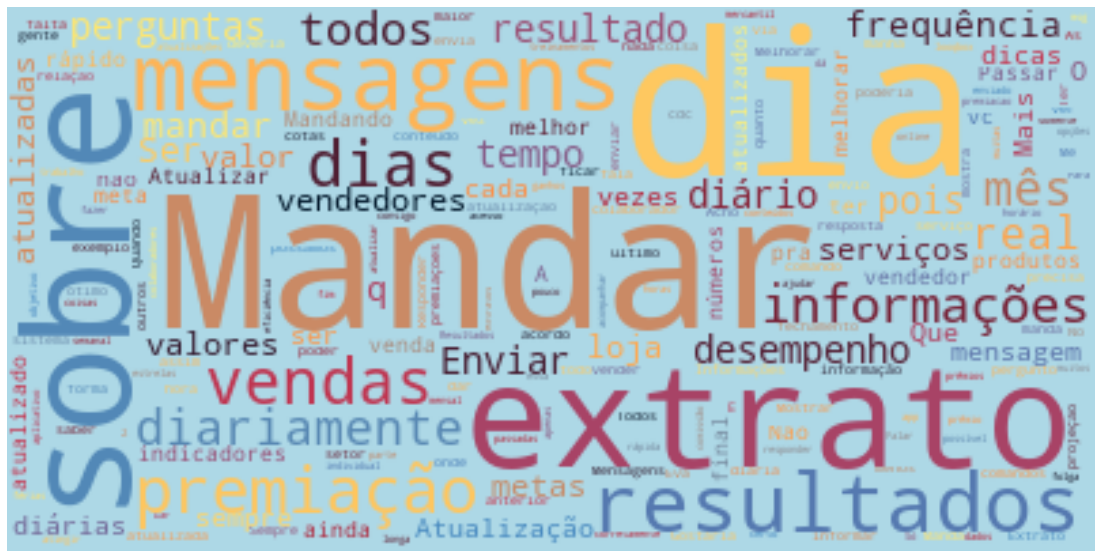

In [21]:
# Exibindo principais palavras relacionadas à classe negativa
hero.visualization.wordcloud(df[df['class'] == 'negativa']['clean'], background_color='lightblue');

In [22]:
# Diferença de stemização entre palavras com e sem acento
stemmer = PortugueseStemmer()
print(stemmer.stem('informacao'))
print(stemmer.stem('informação'))

informaca
inform


### Pré-processamento dos dados

In [23]:
stop_words = nltk.corpus.stopwords.words('portuguese')
# removing stop_words
stop_words = set(stop_words)
stop_words.update(['dia','q','pra','pro','vc','vcs'])
stop_words

{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'dia',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houveríamos',
 'hou

In [24]:
# Pipeline de pré-processamento
prep_pipeline = [preprocessing.fillna,
                 preprocessing.lowercase,
                 preprocessing.remove_whitespace,
                 preprocessing.remove_digits,
                 preprocessing.remove_punctuation,
                 preprocessing.remove_diacritics]

In [25]:
# Aplicando o pipeline de pré-processamento dos textos
df_prep['sentence'] = hero.preprocessing.remove_stopwords(df_prep['sentence'], stop_words)
df_prep['sentence'] = hero.preprocessing.clean(df_prep['sentence'], prep_pipeline)
df_prep

,sentence,class
0,informacoes,positiva
1,dar sugestoes melhorias novos colaboradores,positiva
2,informacoes sal cal,positiva
3,analise relatorio cursos realizados uvv colabo...,positiva
4,esta otimo,positiva
...,...,...
1608,ta ok assim,positiva
1609,mmuitobom,positiva
1610,continuando asim,positiva
1611,nada,positiva


In [26]:
# Criação da coluna com a variável resposta em formato numérico
target = {'positiva': 0, 'negativa': 1}
df_prep['target'] = df_prep['class'].map(target)
df_prep

,sentence,class,target
0,informacoes,positiva,0
1,dar sugestoes melhorias novos colaboradores,positiva,0
2,informacoes sal cal,positiva,0
3,analise relatorio cursos realizados uvv colabo...,positiva,0
4,esta otimo,positiva,0
...,...,...,...
1608,ta ok assim,positiva,0
1609,mmuitobom,positiva,0
1610,continuando asim,positiva,0
1611,nada,positiva,0


In [27]:
# Excluindo a coluna 'class' agora que já existe a informação do target em formato int
df_prep = df_prep.drop('class', axis=1)
df_prep

,sentence,target
0,informacoes,0
1,dar sugestoes melhorias novos colaboradores,0
2,informacoes sal cal,0
3,analise relatorio cursos realizados uvv colabo...,0
4,esta otimo,0
...,...,...
1608,ta ok assim,0
1609,mmuitobom,0
1610,continuando asim,0
1611,nada,0


In [28]:
# Salvando o dataframe com as tranformações do pré-rpocessamento
print('Salvando o arquivo com os elementos textuais pré-processsados...')
df_prep.to_csv('dataset_prep.csv', index=False)
print('Ok!')

Salvando o arquivo com os elementos textuais pré-processsados...
Ok!


In [29]:
# carregando a base de dados já pré-processada
df_prep = pd.read_csv('dataset_prep.csv')
df_prep.head()

,sentence,target
0,informacoes,0
1,dar sugestoes melhorias novos colaboradores,0
2,informacoes sal cal,0
3,analise relatorio cursos realizados uvv colabo...,0
4,esta otimo,0


### Modelagem NLP

In [30]:
# Vetorização dos elementos textuais
# Unigrama + CountVectorizer
vectorizer_cv = CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
vectorizer_cv.fit(df_prep.sentence)
cv_unigram = vectorizer_cv.transform(df_prep.sentence)
cv_unigram

<1611x2188 sparse matrix of type '<class 'numpy.int64'>'
	with 9051 stored elements in Compressed Sparse Row format>

In [31]:
# Exibindo Bag of Words
# Unigrama + CountVectorizer
cv_unigram = pd.DataFrame(cv_unigram.toarray(), columns=vectorizer_cv.get_feature_names())
print('BoW: Unigrama + CountVectorizer')
print(cv_unigram.head(), cv_unigram.shape)

BoW: Unigrama + CountVectorizer
   100assim  10x  6vezes  70apos  830hrs  aba  abaixamos  abaixo  \
0         0    0       0       0       0    0          0       0   
1         0    0       0       0       0    0          0       0   
2         0    0       0       0       0    0          0       0   
3         0    0       0       0       0    0          0       0   
4         0    0       0       0       0    0          0       0   

   abastecimento  abc  ...  voltados  voltar  voltaremos  volume  vontads  \
0              0    0  ...         0       0           0       0        0   
1              0    0  ...         0       0           0       0        0   
2              0    0  ...         0       0           0       0        0   
3              0    0  ...         0       0           0       0        0   
4              0    0  ...         0       0           0       0        0   

   vou  voz  vzs  web  wi  
0    0    0    0    0   0  
1    0    0    0    0   0  
2    0    0 

In [32]:
# Bigrama + CountVectorizer
vectorizer_cv2 = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
vectorizer_cv2.fit(df_prep.sentence)
cv_bigram = vectorizer_cv2.transform(df_prep.sentence)
cv_bigram

<1611x6579 sparse matrix of type '<class 'numpy.int64'>'
	with 7700 stored elements in Compressed Sparse Row format>

In [33]:
# Exibindo Bag of Words
# Bigrama + CountVectorizer
cv_bigram = pd.DataFrame(cv_bigram.toarray(), columns=vectorizer_cv2.get_feature_names())
print('BoW: Bigrama + CountVectorizer')
print(cv_bigram.head(), cv_bigram.shape)

BoW: Bigrama + CountVectorizer
   100assim ganha  10x juros  10x toda  70apos implantacao  aba recursos  \
0               0          0         0                   0             0   
1               0          0         0                   0             0   
2               0          0         0                   0             0   
3               0          0         0                   0             0   
4               0          0         0                   0             0   

   abaixamos ir  abaixo pior  abaixo resultado  abastecimento produtos  \
0             0            0                 0                       0   
1             0            0                 0                       0   
2             0            0                 0                       0   
3             0            0                 0                       0   
4             0            0                 0                       0   

   abertas sistema  ...  vou adequando  vou ganhar  vou gostar  vou

In [34]:
# Unigrama + TF-IDF Vectorizer
vectorizer_tf = TfidfVectorizer(analyzer='word', use_idf=True, ngram_range=(1, 1), stop_words=stop_words)
vectorizer_tf.fit(df_prep.sentence)
tf_unigram = vectorizer_tf.transform(df_prep.sentence)
tf_unigram

<1611x2188 sparse matrix of type '<class 'numpy.float64'>'
	with 9051 stored elements in Compressed Sparse Row format>

In [35]:
# Exibindo Bag of Words
# Unigrama + TF-IDF
tf_unigram = pd.DataFrame(tf_unigram.toarray(), columns=vectorizer_tf.get_feature_names())
print('BoW: Unigrama + TF-IDF')
print(tf_unigram.head(), tf_unigram.shape)

BoW: Unigrama + TF-IDF
   100assim  10x  6vezes  70apos  830hrs  aba  abaixamos  abaixo  \
0       0.0  0.0     0.0     0.0     0.0  0.0        0.0     0.0   
1       0.0  0.0     0.0     0.0     0.0  0.0        0.0     0.0   
2       0.0  0.0     0.0     0.0     0.0  0.0        0.0     0.0   
3       0.0  0.0     0.0     0.0     0.0  0.0        0.0     0.0   
4       0.0  0.0     0.0     0.0     0.0  0.0        0.0     0.0   

   abastecimento  abc  ...  voltados  voltar  voltaremos  volume  vontads  \
0            0.0  0.0  ...       0.0     0.0         0.0     0.0      0.0   
1            0.0  0.0  ...       0.0     0.0         0.0     0.0      0.0   
2            0.0  0.0  ...       0.0     0.0         0.0     0.0      0.0   
3            0.0  0.0  ...       0.0     0.0         0.0     0.0      0.0   
4            0.0  0.0  ...       0.0     0.0         0.0     0.0      0.0   

   vou  voz  vzs  web   wi  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  

In [36]:
# Bigrama + TF-IDF Vectorizer
vectorizer_tf2 = TfidfVectorizer(analyzer='word', use_idf=True, ngram_range=(2, 2), stop_words=stop_words)
vectorizer_tf2.fit(df_prep.sentence)
tf_bigram = vectorizer_tf2.transform(df_prep.sentence)
tf_bigram

<1611x6579 sparse matrix of type '<class 'numpy.float64'>'
	with 7700 stored elements in Compressed Sparse Row format>

In [37]:
# Exibindo Bag of Words
# Bigrama + TF-IDF
tf_bigram = pd.DataFrame(tf_bigram.toarray(), columns=vectorizer_tf2.get_feature_names())
print('BoW: Bigrama + TF-IDF')
print(tf_bigram.head(), tf_bigram.shape)

BoW: Bigrama + TF-IDF
   100assim ganha  10x juros  10x toda  70apos implantacao  aba recursos  \
0             0.0        0.0       0.0                 0.0           0.0   
1             0.0        0.0       0.0                 0.0           0.0   
2             0.0        0.0       0.0                 0.0           0.0   
3             0.0        0.0       0.0                 0.0           0.0   
4             0.0        0.0       0.0                 0.0           0.0   

   abaixamos ir  abaixo pior  abaixo resultado  abastecimento produtos  \
0           0.0          0.0               0.0                     0.0   
1           0.0          0.0               0.0                     0.0   
2           0.0          0.0               0.0                     0.0   
3           0.0          0.0               0.0                     0.0   
4           0.0          0.0               0.0                     0.0   

   abertas sistema  ...  vou adequando  vou ganhar  vou gostar  vou passa  \

### Técnicas de redução de dimensionalidade

In [38]:
# Aplicando SVD para verificar a necessidade de redução de dimensionalidade 
# Unigrama + CountVectorizer
svd = TruncatedSVD(n_components=50, n_iter=20, random_state=seed_value)
svd.fit(cv_unigram)
cv_unigram_svd = svd.transform(cv_unigram)

print('Explained Variance Ratio:')
print(svd.explained_variance_ratio_)
print('\n')
print('Explained Variance Ratio Acumulado:')
print(svd.explained_variance_ratio_.sum())

Explained Variance Ratio:
[0.01632383 0.01626141 0.01403213 0.01325956 0.01245949 0.01177081
 0.01037952 0.01016569 0.00972835 0.00944244 0.00933469 0.00881188
 0.0084031  0.00821674 0.0080247  0.00799218 0.0078696  0.00781372
 0.00762958 0.00729954 0.00726779 0.00721705 0.00701576 0.00665883
 0.00667478 0.00664715 0.0065019  0.00631767 0.00616994 0.00613135
 0.00595939 0.00590426 0.00574617 0.00557427 0.00554888 0.00537594
 0.00524793 0.00515413 0.0050139  0.00491535 0.00482469 0.00477505
 0.00468532 0.00456723 0.00452839 0.0044554  0.0043991  0.00430511
 0.00427162 0.00425543]


Explained Variance Ratio Acumulado:
0.37132874174069236


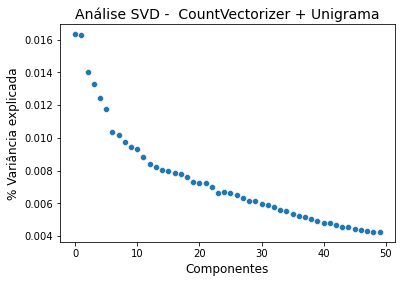

In [39]:
# Exibindo plot da maior variância percentual do número de componentes do SVD
# Unigrama + CountVectorizer
def svd_plot(svd):
    """Plota a variância dos componentes do svd com seaborn;
    A variância é exibida em forma percentual
    """
    sns.scatterplot(y=svd.explained_variance_ratio_, 
                    x=np.arange(len(svd.explained_variance_ratio_)))
    plt.title("Análise SVD -  CountVectorizer + Unigrama", fontsize=14)
    plt.xlabel("Componentes", fontsize=12)
    plt.ylabel("% Variância explicada", fontsize=12)
    plt.show()
svd_plot(svd)

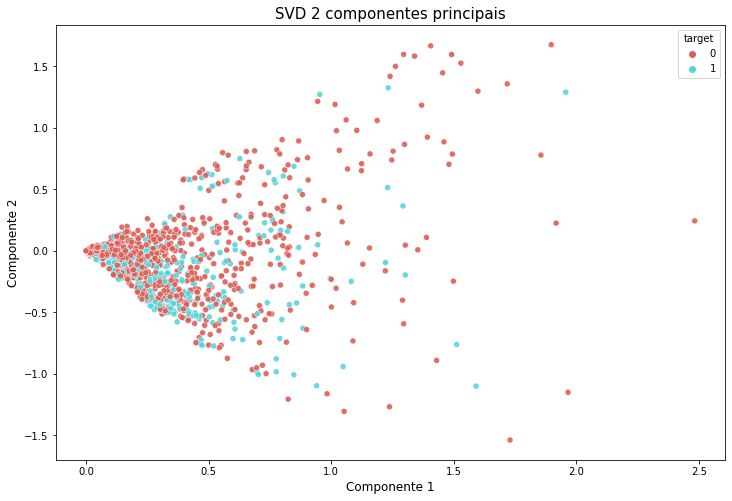

In [40]:
# Plotando os 2 principais componentes do SVD
svd = svd.transform(cv_unigram)
plt.figure(figsize=(12,8))
plt.title('SVD 2 componentes principais', fontsize=15)
plt.xlabel('Componente 1', fontsize=12)
plt.ylabel('Componente 2', fontsize=12)
sns.scatterplot(x=svd[:, 0], y=svd[:, 1], hue=df_prep['target'], palette=sns.color_palette("hls", 2), alpha=0.9);

In [41]:
# Bigrama + CountVectorizer
svd_cv_bigram = TruncatedSVD(n_components=50, n_iter=40, random_state=seed_value)
svd_cv_bigram.fit(cv_bigram)
cv_bigram_svd = svd_cv_bigram.transform(cv_bigram)

print('Explained Variance Ratio:')
print(svd_cv_bigram.explained_variance_ratio_)
print('\n')
print('Explained Variance Ratio Acumulado:')
print(svd_cv_bigram.explained_variance_ratio_.sum())

Explained Variance Ratio:
[0.00525475 0.00467236 0.00473013 0.00429731 0.00419191 0.00413778
 0.00378637 0.00359287 0.0035589  0.00358322 0.00353297 0.0034912
 0.00349316 0.00331706 0.00326945 0.00323643 0.00313731 0.00311963
 0.00310049 0.00308222 0.0030866  0.00304053 0.00302463 0.00299382
 0.00298828 0.00295098 0.00289193 0.0028926  0.00287646 0.00285488
 0.00282159 0.00284549 0.00283983 0.00283579 0.00282795 0.00280123
 0.00279593 0.00274989 0.00277128 0.00274268 0.00271222 0.00271117
 0.00269462 0.00268545 0.00266523 0.00264183 0.00262305 0.00260587
 0.00259995 0.00259515]


Explained Variance Ratio Acumulado:
0.15875246161186837


In [42]:
# Unigrama + TF-IDF
svd_tf_unigram = TruncatedSVD(n_components=50, n_iter=20, random_state=seed_value)
svd_tf_unigram.fit(tf_unigram)
tf_unigram_svd = svd_tf_unigram.transform(tf_unigram)

print('Explained Variance Ratio:')
print(svd_tf_unigram.explained_variance_ratio_)
print('\n')
print('Explained Variance Ratio Acumulado:')
print(svd_tf_unigram.explained_variance_ratio_.sum())

Explained Variance Ratio:
[0.02432149 0.01435569 0.00942171 0.01398555 0.01288814 0.01242267
 0.01164421 0.01055417 0.00951683 0.00954639 0.00827988 0.00789489
 0.00731853 0.00709948 0.00671238 0.00655066 0.00653646 0.00628514
 0.00613279 0.00609156 0.0059213  0.00572912 0.00574766 0.00531804
 0.00529592 0.0050719  0.00503504 0.00495978 0.00483533 0.00474315
 0.00467935 0.00463292 0.00448348 0.0044205  0.00441268 0.00434086
 0.00416687 0.00406485 0.00397044 0.00392637 0.00378618 0.00377003
 0.00373507 0.00358612 0.00352106 0.00349557 0.0034854  0.00342359
 0.00333715 0.00328908]


Explained Variance Ratio Acumulado:
0.32874339890845433


In [43]:
# Bigrama + CountVectorizer
svd_tf_bigram = TruncatedSVD(n_components=50, n_iter=20, random_state=seed_value)
svd_tf_bigram.fit(tf_bigram)
tf_bigram_svd = svd_tf_bigram.transform(tf_bigram)

print('Explained Variance Ratio:')
print(svd_tf_bigram.explained_variance_ratio_)
print('\n')
print('Explained Variance Ratio Acumulado:')
print(svd_tf_bigram.explained_variance_ratio_.sum())

Explained Variance Ratio:
[0.01901654 0.00657889 0.0050537  0.00325551 0.00303582 0.00296464
 0.00291373 0.00290694 0.00283285 0.0028812  0.00286115 0.00282737
 0.00274218 0.00264517 0.00248341 0.00232969 0.00232041 0.00231798
 0.0022637  0.00221144 0.00211096 0.00207329 0.00200178 0.00192966
 0.00190372 0.00189725 0.00182065 0.00181458 0.00181822 0.00176692
 0.00174965 0.0017415  0.00172    0.00160196 0.00158246 0.00157484
 0.00154543 0.00153121 0.00150107 0.00150125 0.00149369 0.00148711
 0.0014834  0.00147189 0.00143624 0.00141867 0.00141859 0.00141242
 0.00141211 0.00140495]


Explained Variance Ratio Acumulado:
0.12606778581950676


In [44]:
cv_unigram_svd.shape

(1611, 50)

### Treinando os classificadores

In [45]:
# Aplicando hold-out para separar as bases de treino e teste para cada método de vetorização

# Unigrama + CountVectorizer
X_trainUCV, X_testUCV, y_trainUCV, y_testUCV = train_test_split(cv_unigram, df_prep.target, test_size=0.2, random_state=seed_value)

# Unigrama + TF-IDF Vectorizer
X_trainUIDF, X_testUIDF, y_trainUIDF, y_testUIDF = train_test_split(cv_bigram, df_prep.target, test_size=0.2, random_state=seed_value)

# Bigrama + CountVectorizer
X_trainBCV, X_testBCV, y_trainBCV, y_testBCV = train_test_split(tf_unigram, df_prep.target, test_size=0.2, random_state=seed_value)

# Bigrama + TF-IDF Vectorizer
X_trainBIDF, X_testBIDF, y_trainBIDF, y_testBIDF = train_test_split(tf_bigram, df_prep.target, test_size=0.2, random_state=seed_value)

In [46]:
# Validação cruzada com Stratifield Kfold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)
skf

StratifiedKFold(n_splits=10, random_state=1313, shuffle=True)

In [47]:
# Decision Tree Classifier

starttime = timeit.default_timer()
print('Treinando Decision Tree Classifier...')
tree_model = DecisionTreeClassifier(random_state=seed_value)

print('Exibindo acurácia na base de teste com Stratified Kfold = 10...')

# Unigrama + CountVectorizer
tree_model.fit(X_trainUCV, y_trainUCV)
y_predictionUCV = tree_model.predict(X_testUCV)
resultsUCV_tree = cross_validate(tree_model, X=X_testUCV, y=y_testUCV, cv=skf)
print('Acurária Unigrama + CountVectorizer: %f (%f)' %(resultsUCV_tree['test_score'].mean(), 
                                                       resultsUCV_tree['test_score'].std()))

# Unigrama + TF-IDF Vectorizer
tree_model.fit(X_trainUIDF, y_trainUIDF)
y_predictionUIDF = tree_model.predict(X_testUIDF)
resultsUIDF_tree = cross_validate(tree_model, X=X_testUIDF, y=y_testUIDF, cv=skf)
print('Acurária Unigrama + TF-IDF Vectorizer: %f (%f)' %(resultsUIDF_tree['test_score'].mean(), 
                                                         resultsUIDF_tree['test_score'].std()))

# Bigrama + CountVectorizer
tree_model.fit(X_trainBCV, y_trainBCV)
y_predictionBCV = tree_model.predict(X_testBCV)
resultsBCV_tree  = cross_validate(tree_model, X=X_testBCV, y=y_testBCV, cv=skf)
print('Acurária Bigrama + CountVectorizer: %f (%f)' %(resultsBCV_tree['test_score'].mean(), 
                                                      resultsBCV_tree['test_score'].std()))

# Bigrama + TF-IDF Vectorizer
tree_model.fit(X_trainBIDF, y_trainBIDF)
y_predictionBIDF = tree_model.predict(X_testBIDF)
resultsBIDF_tree  = cross_validate(tree_model, X=X_testBIDF, y=y_testBIDF, cv=skf)
print('Acurária Bigrama + TF-IDF Vectorizer: %f (%f)' %(resultsBIDF_tree['test_score'].mean(), 
                                                        resultsBIDF_tree['test_score'].std()))

print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Treinando Decision Tree Classifier...
Exibindo acurácia na base de teste com Stratified Kfold = 10...
Acurária Unigrama + CountVectorizer: 0.742898 (0.040190)
Acurária Unigrama + TF-IDF Vectorizer: 0.749527 (0.029540)
Acurária Bigrama + CountVectorizer: 0.767803 (0.044307)
Acurária Bigrama + TF-IDF Vectorizer: 0.746402 (0.033953)
Ok!
Total time: 67.9302662


In [48]:
# Naive Bayes Multinomial

starttime = timeit.default_timer()
print('Treinando Multinomial Naive Bayes...')
nb_model = MultinomialNB()

print('Exibindo acurácia na base de teste com Stratified Kfold = 10...')

# Unigrama + CountVectorizer
nb_model.fit(X_trainUCV, y_trainUCV)
y_predictionUCV = nb_model.predict(X_testUCV)
resultsUCV_nb = cross_validate(nb_model, X=X_testUCV, y=y_testUCV, cv=skf)
print('Acurária Unigrama + CountVectorizer: %f (%f)' %(resultsUCV_nb['test_score'].mean(), 
                                                       resultsUCV_nb['test_score'].std()))

# Unigrama + TF-IDF Vectorizer
nb_model.fit(X_trainUIDF, y_trainUIDF)
y_predictionUIDF = nb_model.predict(X_testUIDF)
resultsUIDF_nb  = cross_validate(nb_model, X=X_testUIDF, y=y_testUIDF, cv=skf)
print('Acurária Unigrama + TF-IDF Vectorizer: %f (%f)' %(resultsUIDF_nb['test_score'].mean(), 
                                                         resultsUIDF_nb['test_score'].std()))

# Bigrama + CountVectorizer
nb_model.fit(X_trainBCV, y_trainBCV)
y_predictionBCV = nb_model.predict(X_testBCV)
resultsBCV_nb = cross_validate(nb_model, X=X_testBCV, y=y_testBCV, cv=skf)
print('Acurária Bigrama + CountVectorizer: %f (%f)' %(resultsBCV_nb['test_score'].mean(), 
                                                      resultsBCV_nb['test_score'].std()))

# Bigrama + TF-IDF Vectorizer
nb_model.fit(X_trainBIDF, y_trainBIDF)
y_predictionBIDF = nb_model.predict(X_testBIDF)
resultsBIDF_nb = cross_validate(nb_model, X=X_testBIDF, y=y_testBIDF, cv=skf)
print('Acurária Bigrama + TF-IDF Vectorizer: %f (%f)' %(resultsBIDF_nb['test_score'].mean(), 
                                                        resultsBIDF_nb['test_score'].std()))

print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Treinando Multinomial Naive Bayes...
Exibindo acurácia na base de teste com Stratified Kfold = 10...
Acurária Unigrama + CountVectorizer: 0.786174 (0.027225)
Acurária Unigrama + TF-IDF Vectorizer: 0.730682 (0.041230)
Acurária Bigrama + CountVectorizer: 0.739867 (0.028567)
Acurária Bigrama + TF-IDF Vectorizer: 0.715246 (0.009480)
Ok!
Total time: 5.010747800000004


In [49]:
# Light Gradient Boost

starttime = timeit.default_timer()
print('Treinando Light Gradient Boost...')
lgbm_model = lgb.LGBMClassifier(num_leaves=25, 
                                n_estimators=150, 
                                max_depth=8,
                                n_jobs=-1, 
                                random_state=seed_value)

print('Exibindo acurácia na base de teste com Stratified Kfold = 10...')

# Unigrama + CountVectorizer
lgbm_model.fit(X_trainUCV.astype(float), y_trainUCV.astype(float))
y_predictionUCV = lgbm_model.predict(X_testUCV.astype(float))
resultsUCV_lgbm = cross_validate(lgbm_model, X=X_testUCV, y=y_testUCV, cv=skf)
print('Acurária Unigrama + CountVectorizer: %f (%f)' %(resultsUCV_lgbm['test_score'].mean(), 
                                                       resultsUCV_lgbm['test_score'].std()))

# Unigrama + TF-IDF Vectorizer
lgbm_model.fit(X_trainUIDF.astype(float), y_trainUIDF.astype(float))
y_predictionUIDF = lgbm_model.predict(X_testUIDF.astype(float))
resultsUIDF_lgbm  = cross_validate(lgbm_model, X=X_testUIDF, y=y_testUIDF, cv=skf)
print('Acurária Unigrama + TF-IDF Vectorizer: %f (%f)' %(resultsUIDF_lgbm['test_score'].mean(), 
                                                         resultsUIDF_lgbm['test_score'].std()))

# Bigrama + CountVectorizer
lgbm_model.fit(X_trainBCV.astype(float), y_trainBCV.astype(float))
y_predictionBCV = lgbm_model.predict(X_testBCV.astype(float))
resultsBCV_lgbm  = cross_validate(lgbm_model, X=X_testBCV, y=y_testBCV, cv=skf)
print('Acurária Bigrama + CountVectorizer: %f (%f)' %(resultsBCV_lgbm['test_score'].mean(), 
                                                      resultsBCV_lgbm['test_score'].std()))

# Bigrama + TF-IDF Vectorizer
lgbm_model.fit(X_trainBIDF.astype(float), y_trainBIDF.astype(float))
y_predictionBIDF = lgbm_model.predict(X_testBIDF.astype(float))
resultsBIDF_lgbm  = cross_validate(lgbm_model, X=X_testBIDF, y=y_testBIDF, cv=skf)
print('Acurária Bigrama + TF-IDF Vectorizer: %f (%f)' %(resultsBIDF_lgbm['test_score'].mean(), 
                                                        resultsBIDF_lgbm['test_score'].std()))

print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Treinando Light Gradient Boost...
Exibindo acurácia na base de teste com Stratified Kfold = 10...
Acurária Unigrama + CountVectorizer: 0.715246 (0.009480)
Acurária Unigrama + TF-IDF Vectorizer: 0.715246 (0.009480)
Acurária Bigrama + CountVectorizer: 0.715246 (0.009480)
Acurária Bigrama + TF-IDF Vectorizer: 0.715246 (0.009480)
Ok!
Total time: 10.664888399999995


In [50]:
dict_results = {'UCV_tree':resultsUCV_tree['test_score'].mean(),
               'UIDF_tree':resultsUIDF_tree['test_score'].mean(),
               'BCV_tree':resultsBCV_tree['test_score'].mean(),
               'BIDF_tree':resultsBIDF_tree['test_score'].mean(),
               'UCV_nb':resultsUCV_nb['test_score'].mean(),
               'UIDF_nb':resultsUIDF_nb['test_score'].mean(),
               'BCV_nb':resultsBCV_nb['test_score'].mean(),
               'BIDF_nb':resultsBIDF_nb['test_score'].mean(),
               'UCV_lgbm':resultsUCV_lgbm['test_score'].mean(),
               'UIDF_lgbm':resultsUIDF_lgbm['test_score'].mean(),
               'BCV_lgbm':resultsBCV_lgbm['test_score'].mean(),
               'BIDF_lgbm':resultsBIDF_lgbm['test_score'].mean()}

dict_results

{'UCV_tree': 0.7428977272727273,
 'UIDF_tree': 0.7495265151515151,
 'BCV_tree': 0.7678030303030303,
 'BIDF_tree': 0.7464015151515151,
 'UCV_nb': 0.7861742424242424,
 'UIDF_nb': 0.7306818181818182,
 'BCV_nb': 0.7398674242424242,
 'BIDF_nb': 0.7152462121212121,
 'UCV_lgbm': 0.7152462121212121,
 'UIDF_lgbm': 0.7152462121212121,
 'BCV_lgbm': 0.7152462121212121,
 'BIDF_lgbm': 0.7152462121212121}

In [51]:
# criando um data frame para armazenar os resultados do dicionário
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
df_results.reset_index(inplace=True)
df_results.columns=['Modelo', 'Acurácia Média']
df_results = df_results.sort_values(by='Acurácia Média', ascending=False)

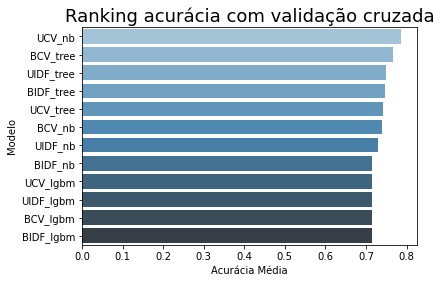

In [52]:
# exibindo o gráfico com a comparação entre acurácia média entre modelos c/ validação cruzada
ax = sns.barplot(x="Acurácia Média", y="Modelo", data=df_results,
                 palette="Blues_d")
ax.set_title('Ranking acurácia com validação cruzada', fontsize=18);

In [96]:
# teste de levene para igualdade de variância entre as amostras
modelo1 = resultsUCV_nb['test_score']
modelo2 = resultsBCV_tree['test_score']
stat, p = levene(modelo1, modelo2)
print('Comparação de igualdade de variância os 2 modelos mais acurados...')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Provavelmente as variâncias são iguais')
else:
    print('Provavelmente as variâncias são diferentes')

Comparação de igualdade de variância os 2 modelos mais acurados...
stat=0.996, p=0.332
Provavelmente as variâncias são iguais


In [97]:
# Example of the Shapiro-Wilk Normality Test
from scipy.stats import shapiro

stat, p = shapiro(modelo1)
print('Verificando a normalidade das amostras: modelo1...')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Provavelmente é normal')
else:
    print('Provavelmente não é normal')
    
print('\n')
    
stat, p = shapiro(modelo2)
print('Verificando a normalidade das amostras: modelo2...')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Provavelmente é normal')
else:
    print('Provavelmente não é normal')

Verificando a normalidade das amostras: modelo1...
stat=0.843, p=0.048
Provavelmente não é normal


Verificando a normalidade das amostras: modelo2...
stat=0.957, p=0.755
Provavelmente é normal


In [98]:
# teste de levene para igualdade de variância entre as amostras
stat, p = ttest_ind(modelo1, modelo2)
print('Comparação de igualdade das médias entre os 2 modelos mais acurados...')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Provavelmente as médias são iguais')
else:
    print('Provavelmente as médias são diferentes')

Comparação de igualdade das médias entre os 2 modelos mais acurados...
stat=1.060, p=0.303
Provavelmente as médias são iguais


In [99]:
# teste Bayesiano hierárquico para comparação de modelos
print('Teste Bayesiano Hierárquico')
print('Probabilidade do modelo1 ser melhor do que o modelo2...')
print(baycomp.two_on_single(modelo1, modelo2))

Teste Bayesiano Hierárquico
Probabilidade do modelo1 ser melhor do que o modelo2...
(0.75687929633051, 0.24312070366949)


(0.005192884461102199, 0.9942296751776266, 0.0005774403612711643)


c:\users\2104411064\anaconda3\envs\ad_env_v2\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



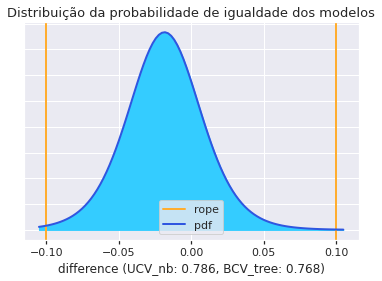

In [114]:
# avaliando a possibilidade de igualdade dos modelos 
names = ("UCV_nb", "BCV_tree")
probs, fig = baycomp.two_on_single(modelo1, modelo2, rope=0.1, plot=True, names=names)
print(probs)
plt.title('Distribuição da probabilidade de igualdade dos modelos', fontsize=13)
fig.show();

### Redes Neurais

In [58]:
df_prep

,sentence,target
0,informacoes,0
1,dar sugestoes melhorias novos colaboradores,0
2,informacoes sal cal,0
3,analise relatorio cursos realizados uvv colabo...,0
4,esta otimo,0
...,...,...
1606,ta ok assim,0
1607,mmuitobom,0
1608,continuando asim,0
1609,nada,0


In [59]:
# Tokenização de palavras
frases = df_prep['sentence']
tokenizer = Tokenizer(oov_token='<OOV>') #definição de token para palavras não existentes no vocabulário de treino
tokens = tokenizer.fit_on_texts(frases)
vocab = tokenizer.word_index
print(vocab)

{'<OOV>': 1, 'premiacao': 2, 'mandar': 3, 'vendas': 4, 'sobre': 5, 'informacoes': 6, 'produtos': 7, 'ir': 8, 'nada': 9, 'nao': 10, 'empresa': 11, 'ter': 12, 'loja': 13, 'resultados': 14, 'servicos': 15, 'dicas': 16, 'todos': 17, 'vendedores': 18, 'ser': 19, 'enviar': 20, 'cada': 21, 'extrato': 22, 'pois': 23, 'melhorar': 24, 'melhor': 25, 'bom': 26, 'a': 27, 'sempre': 28, 'acho': 29, 'cdc': 30, 'mes': 31, 'mensagens': 32, 'venda': 33, 'assim': 34, 'metas': 35, 'o': 36, 'otimo': 37, 'diariamente': 38, 'tudo': 39, 'resultado': 40, 'desempenho': 41, 'vendedor': 42, 'mais': 43, 'vender': 44, 'nenhuma': 45, 'dias': 46, 'continuar': 47, 'meta': 48, 'ajuda': 49, 'valor': 50, 'setor': 51, 'gostaria': 52, 'mandando': 53, 'deveria': 54, 'pagamento': 55, 'esta': 56, 'bem': 57, 'perguntas': 58, 'via': 59, 'forma': 60, 'poderia': 61, 'declarar': 62, 'e': 63, 'diario': 64, 'ta': 65, 'ok': 66, 'no': 67, 'vezes': 68, 'modelo': 69, 'que': 70, 'valores': 71, 'vez': 72, 'indicadores': 73, 'frequencia': 7

In [60]:
# Exibindo os vetores pós-tokenização de palavras
tokens_frases = tokenizer.texts_to_sequences(frases)
tokens_frases

[[6],
 [87, 113, 444, 248, 100],
 [6, 695, 291],
 [1026, 548, 249, 696, 1027, 100, 549],
 [56, 37],
 [43, 6, 250, 33, 7],
 [221, 53, 28, 327, 21, 292, 63, 28, 1028, 1029],
 [70, 101, 34, 53, 550],
 [4],
 [184, 1030, 1031, 1032],
 [114, 5, 697],
 [151, 377, 222, 102, 1033, 102, 5, 14, 293],
 [32, 698],
 [699, 100, 223, 59],
 [3, 328, 5, 4, 7, 445],
 [40, 64, 152],
 [1034, 41, 224, 152, 446, 251],
 [3, 1035, 252, 23, 1036, 1037, 153, 1038, 551, 294],
 [32, 698, 154, 1039, 6, 552],
 [113, 91, 1040],
 [82, 155, 88],
 [156, 329, 1041, 1042, 700, 330, 27, 330],
 [47, 199, 60],
 [378],
 [56, 39, 1043, 1044],
 [157, 253, 379, 72],
 [380, 1045, 701, 702, 331, 1046, 379, 72],
 [381, 703, 1047, 291],
 [1048, 704, 705, 447],
 [87, 165, 1049, 103],
 [381, 44, 15],
 [61, 295, 22, 296, 200, 184, 1050, 448, 158, 73, 24, 2],
 [9, 62],
 [56,
  706,
  382,
  49,
  332,
  553,
  21,
  72,
  21,
  707,
  59,
  185,
  1051,
  708,
  332,
  333,
  449],
 [20, 201, 38],
 [381, 25, 120],
 [29, 26],
 [6, 5, 107

In [61]:
# Aplicando pad_sequences na sequência recém transformada via tokenização
frases_tokens = pad_sequences(tokens_frases, 
                              padding='post', 
                              truncating='post',
                              maxlen=30)
print(frases_tokens)

[[   6    0    0 ...    0    0    0]
 [  87  113  444 ...    0    0    0]
 [   6  695  291 ...    0    0    0]
 ...
 [2256 2257    0 ...    0    0    0]
 [   9    0    0 ...    0    0    0]
 [   9   62    0 ...    0    0    0]]


In [62]:
# Separando as bases de treino, teste e validação
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(frases_tokens, df_prep['target'], test_size=0.2, random_state=42)

# Bases de treino parcial + validação
# Para garantir a consistência dos resultados antes de validar nas bases teste
X_val_pad = X_train_pad[:250]
partial_X_train = X_train_pad[250:]

y_val_pad = y_train_pad[:250]
partial_y_train = y_train_pad[250:]

In [63]:
# Transformação do formato dos dataframes em arrays
partial_X_train = np.array(partial_X_train)
partial_y_train = np.array(partial_y_train)

X_val_pad = np.array(X_val_pad)
y_val_pad = np.array(y_val_pad)

X_test_pad = np.array(X_test_pad)
y_test_pad = np.array(y_test_pad)

In [64]:
# Definição do número de neurônios da camada embedding e do vetor de palavras vocabulário
embedding_dim = 256
vocab_size = 6500 #selecionando as 6000 palavras mais frequentes do vocabulário

In [65]:
# Definindo a função do scheduler com decaimento exponencial a partir da época 5
def scheduler(epoch, lr):
    print("Learning rate atual: ", lr)
    if epoch <= 4:
        return lr
    else:
        return np.clip(lr * tf.math.exp(-0.4), 0.0001, 0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [66]:
# Primeira arquitetura
# Camada Embedding + GAP 1D + Dense

model1 = Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_emb1')

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       'AUC',
                       'binary_accuracy'])

model1.summary()

Model: "model_emb1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         1664000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,672,257
Trainable params: 1,672,257
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Fit do modelo
starttime = timeit.default_timer()
history_pad1 = model1.fit(partial_X_train, 
                        partial_y_train,
                        batch_size=32,
                        epochs=50,
                        validation_data=(X_val_pad, y_val_pad), 
                        verbose=1,
                        callbacks=[callback])
print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Learning rate atual:  0.0010000000474974513
Epoch 1/50
33/33 [==============================] - 1s 44ms/step - loss: 0.6235 - accuracy: 0.7081 - auc: 0.5346 - binary_accuracy: 0.7081 - val_loss: 0.6216 - val_accuracy: 0.6920 - val_auc: 0.5679 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 2/50
33/33 [==============================] - 1s 36ms/step - loss: 0.5936 - accuracy: 0.7081 - auc: 0.6263 - binary_accuracy: 0.7081 - val_loss: 0.6087 - val_accuracy: 0.6920 - val_auc: 0.6531 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 3/50
33/33 [==============================] - 1s 34ms/step - loss: 0.5707 - accuracy: 0.7081 - auc: 0.8119 - binary_accuracy: 0.7081 - val_loss: 0.5902 - val_accuracy: 0.6920 - val_auc: 0.7834 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 4/50
33/33 [==============================] - 1s 34ms/step - loss: 0.5267 - accuracy: 0.7119 - auc: 0.9051 - binary_accuracy: 0.711

Learning rate atual:  9.999999747378752e-05
Epoch 31/50
33/33 [==============================] - 1s 34ms/step - loss: 0.1702 - accuracy: 0.9470 - auc: 0.9852 - binary_accuracy: 0.9470 - val_loss: 0.4063 - val_accuracy: 0.8200 - val_auc: 0.8781 - val_binary_accuracy: 0.8200
Learning rate atual:  9.999999747378752e-05
Epoch 32/50
33/33 [==============================] - 1s 32ms/step - loss: 0.1682 - accuracy: 0.9470 - auc: 0.9854 - binary_accuracy: 0.9470 - val_loss: 0.4075 - val_accuracy: 0.8200 - val_auc: 0.8780 - val_binary_accuracy: 0.8200
Learning rate atual:  9.999999747378752e-05
Epoch 33/50
33/33 [==============================] - 1s 34ms/step - loss: 0.1658 - accuracy: 0.9461 - auc: 0.9857 - binary_accuracy: 0.9461 - val_loss: 0.4081 - val_accuracy: 0.8200 - val_auc: 0.8781 - val_binary_accuracy: 0.8200
Learning rate atual:  9.999999747378752e-05
Epoch 34/50
33/33 [==============================] - 1s 38ms/step - loss: 0.1636 - accuracy: 0.9461 - auc: 0.9861 - binary_accuracy: 0

In [68]:
# Validando na base de teste
results1 = model1.evaluate(X_test_pad,  y_test_pad, verbose=2)

11/11 - 0s - loss: 0.4388 - accuracy: 0.8421 - auc: 0.8662 - binary_accuracy: 0.8421


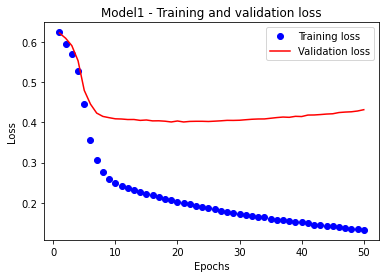

In [69]:
history_dict = history_pad1.history
history_dict.keys()

# Exibindo gráfico de Loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model1 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

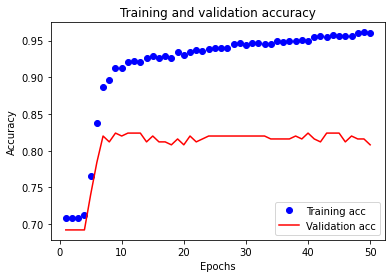

In [70]:
# Exibindo gráfico de Accurácia
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [71]:
# Segunda arquitetura
# Camada Embedding + GRU + Dense

model2 = Sequential([
  layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
  layers.GRU(32),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='softmax'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_emb2')

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       'AUC',
                       'binary_accuracy'])

model2.summary()

Model: "model_emb2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         1664000   
_________________________________________________________________
gru (GRU)                    (None, 32)                27840     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,693,713
Trainable params: 1,693,713
Non-trainable params: 0
______________________________________________

In [72]:
# Fit do modelo
history_pad2 = model2.fit(partial_X_train, 
                          partial_y_train,
                          batch_size=32,
                          epochs=50,
                          validation_data=(X_val_pad, y_val_pad), 
                          verbose=1,
                          callbacks=[callback])
print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Learning rate atual:  0.0010000000474974513
Epoch 1/50
33/33 [==============================] - 3s 92ms/step - loss: 0.6659 - accuracy: 0.7081 - auc: 0.5409 - binary_accuracy: 0.7081 - val_loss: 0.6512 - val_accuracy: 0.6920 - val_auc: 0.7247 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 2/50
33/33 [==============================] - 1s 43ms/step - loss: 0.6125 - accuracy: 0.7081 - auc: 0.7008 - binary_accuracy: 0.7081 - val_loss: 0.5891 - val_accuracy: 0.6920 - val_auc: 0.8091 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 3/50
33/33 [==============================] - 2s 50ms/step - loss: 0.5266 - accuracy: 0.7081 - auc: 0.9213 - binary_accuracy: 0.7081 - val_loss: 0.5247 - val_accuracy: 0.6920 - val_auc: 0.8751 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 4/50
33/33 [==============================] - 1s 43ms/step - loss: 0.4353 - accuracy: 0.7688 - auc: 0.9456 - binary_accuracy: 0.768

Learning rate atual:  9.999999747378752e-05
Epoch 31/50
33/33 [==============================] - 2s 47ms/step - loss: 0.1733 - accuracy: 0.9798 - auc: 0.9815 - binary_accuracy: 0.9798 - val_loss: 0.4533 - val_accuracy: 0.8120 - val_auc: 0.8231 - val_binary_accuracy: 0.8120
Learning rate atual:  9.999999747378752e-05
Epoch 32/50
33/33 [==============================] - 1s 45ms/step - loss: 0.1712 - accuracy: 0.9798 - auc: 0.9829 - binary_accuracy: 0.9798 - val_loss: 0.4543 - val_accuracy: 0.8120 - val_auc: 0.8259 - val_binary_accuracy: 0.8120
Learning rate atual:  9.999999747378752e-05
Epoch 33/50
33/33 [==============================] - 2s 47ms/step - loss: 0.1694 - accuracy: 0.9788 - auc: 0.9821 - binary_accuracy: 0.9788 - val_loss: 0.4553 - val_accuracy: 0.8120 - val_auc: 0.8290 - val_binary_accuracy: 0.8120
Learning rate atual:  9.999999747378752e-05
Epoch 34/50
33/33 [==============================] - 2s 60ms/step - loss: 0.1671 - accuracy: 0.9798 - auc: 0.9815 - binary_accuracy: 0

In [73]:
# Validando na base de teste
results2 = model2.evaluate(X_test_pad,  y_test_pad, verbose=2)

11/11 - 0s - loss: 0.4813 - accuracy: 0.7988 - auc: 0.8251 - binary_accuracy: 0.7988


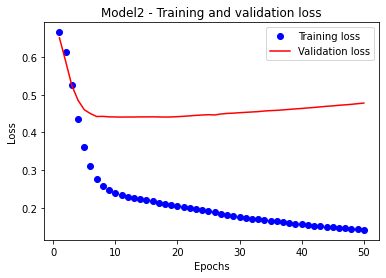

In [74]:
history_dict = history_pad2.history
history_dict.keys()

# Exibindo gráfico de Loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model2 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

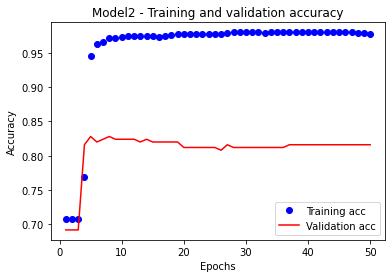

In [75]:
# Exibindo gráfico de Accurácia
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Model2 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [76]:
# Terceira arquitetura
# Camada Embedding + SimpleRNN + Dense
model3 = Sequential([
  layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
  layers.SimpleRNN(units=64),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='softmax'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_emb3')

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       'AUC',
                       'binary_accuracy'])

model3.summary()

Model: "model_emb3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         1664000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                20544     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,687,441
Trainable params: 1,687,441
Non-trainable params: 0
______________________________________________

In [77]:
# Fit do Modelo
starttime = timeit.default_timer()
history_pad3 = model3.fit(partial_X_train, 
                        partial_y_train,
                        batch_size=32,
                        epochs=50,
                        validation_data=(X_val_pad, y_val_pad), 
                        verbose=1,
                        callbacks=[callback])
print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Learning rate atual:  0.0010000000474974513
Epoch 1/50
33/33 [==============================] - 2s 50ms/step - loss: 0.6788 - accuracy: 0.6657 - auc: 0.5434 - binary_accuracy: 0.6657 - val_loss: 0.6589 - val_accuracy: 0.6920 - val_auc: 0.6077 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 2/50
33/33 [==============================] - 1s 37ms/step - loss: 0.6305 - accuracy: 0.7081 - auc: 0.7278 - binary_accuracy: 0.7081 - val_loss: 0.6155 - val_accuracy: 0.6920 - val_auc: 0.7652 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 3/50
33/33 [==============================] - 1s 41ms/step - loss: 0.5582 - accuracy: 0.8160 - auc: 0.9020 - binary_accuracy: 0.8160 - val_loss: 0.5595 - val_accuracy: 0.7960 - val_auc: 0.8018 - val_binary_accuracy: 0.7960
Learning rate atual:  0.0010000000474974513
Epoch 4/50
33/33 [==============================] - 1s 40ms/step - loss: 0.4703 - accuracy: 0.9181 - auc: 0.9271 - binary_accuracy: 0.918

Learning rate atual:  9.999999747378752e-05
Epoch 31/50
33/33 [==============================] - 1s 39ms/step - loss: 0.1101 - accuracy: 0.9933 - auc: 0.9991 - binary_accuracy: 0.9933 - val_loss: 0.5433 - val_accuracy: 0.7680 - val_auc: 0.7868 - val_binary_accuracy: 0.7680
Learning rate atual:  9.999999747378752e-05
Epoch 32/50
33/33 [==============================] - 1s 45ms/step - loss: 0.1076 - accuracy: 0.9942 - auc: 0.9988 - binary_accuracy: 0.9942 - val_loss: 0.5446 - val_accuracy: 0.7680 - val_auc: 0.7797 - val_binary_accuracy: 0.7680
Learning rate atual:  9.999999747378752e-05
Epoch 33/50
33/33 [==============================] - 2s 52ms/step - loss: 0.1053 - accuracy: 0.9933 - auc: 0.9992 - binary_accuracy: 0.9933 - val_loss: 0.5497 - val_accuracy: 0.7680 - val_auc: 0.7784 - val_binary_accuracy: 0.7680
Learning rate atual:  9.999999747378752e-05
Epoch 34/50
33/33 [==============================] - 2s 54ms/step - loss: 0.1026 - accuracy: 0.9942 - auc: 0.9996 - binary_accuracy: 0

In [78]:
# Validando na base de teste
results3 = model3.evaluate(X_test_pad,  y_test_pad, verbose=2)

11/11 - 0s - loss: 0.5608 - accuracy: 0.7771 - auc: 0.7889 - binary_accuracy: 0.7771


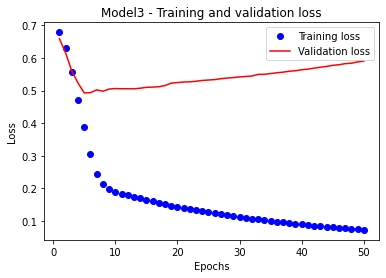

In [79]:
history_dict = history_pad3.history
history_dict.keys()

# Exibindo gráfico de Loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model3 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

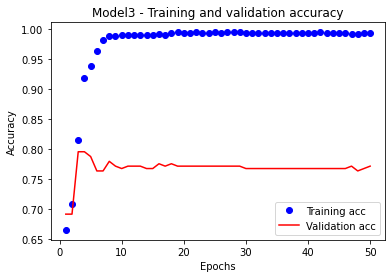

In [80]:
# Exibindo gráfico de Accurácia
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Model3 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [81]:
# Quarta arquitetura
# Camada Embedding + Bidirectional Layer LSTM + Dense
model4 = Sequential([
  layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
  layers.Bidirectional(layers.LSTM(32)),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='softmax'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_emb4')

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       'AUC',
                       'binary_accuracy'])

model4.summary()

Model: "model_emb4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         1664000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                73984     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 1,740,881
Trainable params: 1,740,881
Non-trainable params: 0
______________________________________________

In [82]:
# Fit do modelo
starttime = timeit.default_timer()
history_pad4 = model4.fit(partial_X_train, 
                        partial_y_train,
                        batch_size=32,
                        epochs=50,
                        validation_data=(X_val_pad, y_val_pad), 
                        verbose=1,
                        callbacks=[callback])
print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Learning rate atual:  0.0010000000474974513
Epoch 1/50
33/33 [==============================] - 5s 140ms/step - loss: 0.6907 - accuracy: 0.5472 - auc: 0.5332 - binary_accuracy: 0.5472 - val_loss: 0.6788 - val_accuracy: 0.6920 - val_auc: 0.5757 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 2/50
33/33 [==============================] - 2s 52ms/step - loss: 0.6431 - accuracy: 0.7081 - auc: 0.6153 - binary_accuracy: 0.7081 - val_loss: 0.6056 - val_accuracy: 0.6920 - val_auc: 0.7751 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 3/50
33/33 [==============================] - 2s 53ms/step - loss: 0.5541 - accuracy: 0.7081 - auc: 0.8833 - binary_accuracy: 0.7081 - val_loss: 0.5451 - val_accuracy: 0.6920 - val_auc: 0.8517 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 4/50
33/33 [==============================] - 2s 56ms/step - loss: 0.4669 - accuracy: 0.8709 - auc: 0.9320 - binary_accuracy: 0.87

Learning rate atual:  9.999999747378752e-05
Epoch 31/50
33/33 [==============================] - 2s 52ms/step - loss: 0.2259 - accuracy: 0.9653 - auc: 0.9577 - binary_accuracy: 0.9653 - val_loss: 0.4190 - val_accuracy: 0.8280 - val_auc: 0.8443 - val_binary_accuracy: 0.8280
Learning rate atual:  9.999999747378752e-05
Epoch 32/50
33/33 [==============================] - 2s 51ms/step - loss: 0.2237 - accuracy: 0.9653 - auc: 0.9583 - binary_accuracy: 0.9653 - val_loss: 0.4194 - val_accuracy: 0.8280 - val_auc: 0.8428 - val_binary_accuracy: 0.8280
Learning rate atual:  9.999999747378752e-05
Epoch 33/50
33/33 [==============================] - 2s 61ms/step - loss: 0.2218 - accuracy: 0.9653 - auc: 0.9553 - binary_accuracy: 0.9653 - val_loss: 0.4198 - val_accuracy: 0.8280 - val_auc: 0.8437 - val_binary_accuracy: 0.8280
Learning rate atual:  9.999999747378752e-05
Epoch 34/50
33/33 [==============================] - 2s 70ms/step - loss: 0.2196 - accuracy: 0.9653 - auc: 0.9570 - binary_accuracy: 0

In [83]:
# Validando na base de teste
results4 = model4.evaluate(X_test_pad, y_test_pad, verbose=2)

11/11 - 0s - loss: 0.4580 - accuracy: 0.8111 - auc: 0.8260 - binary_accuracy: 0.8111


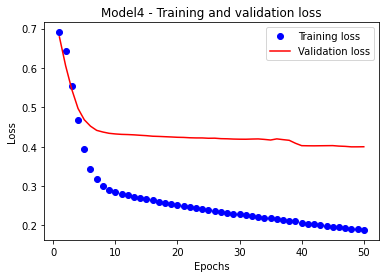

In [84]:
history_dict = history_pad4.history
history_dict.keys()

# Exibindo gráfico de Loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model4 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

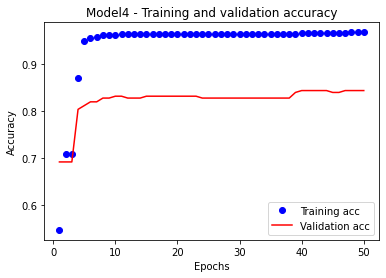

In [85]:
# Exibindo gráfico de Accurácia
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Model4 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [86]:
# Quinta arquitetura
# Embedding + 2 camadas LSTM + Dense
model5 = Sequential([
  layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
  layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
  layers.Bidirectional(layers.LSTM(16)),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='softmax'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_emb5')

model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       'AUC',
                       'binary_accuracy'])

model5.summary()

Model: "model_emb5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         1664000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          73984     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1

In [87]:
# Fit do modelo
starttime = timeit.default_timer()
history_pad5 = model5.fit(partial_X_train, 
                        partial_y_train,
                        batch_size=32,
                        epochs=50,
                        validation_data=(X_val_pad, y_val_pad), 
                        verbose=1,
                        callbacks=[callback])
print('Ok!')
print("Total time:", timeit.default_timer() - starttime)

Learning rate atual:  0.0010000000474974513
Epoch 1/50
33/33 [==============================] - 16s 498ms/step - loss: 0.6430 - accuracy: 0.7081 - auc: 0.5386 - binary_accuracy: 0.7081 - val_loss: 0.6307 - val_accuracy: 0.6920 - val_auc: 0.6287 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 2/50
33/33 [==============================] - 2s 56ms/step - loss: 0.5842 - accuracy: 0.7081 - auc: 0.7466 - binary_accuracy: 0.7081 - val_loss: 0.5638 - val_accuracy: 0.6920 - val_auc: 0.7960 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 3/50
33/33 [==============================] - 2s 62ms/step - loss: 0.4728 - accuracy: 0.7081 - auc: 0.9279 - binary_accuracy: 0.7081 - val_loss: 0.5008 - val_accuracy: 0.6920 - val_auc: 0.8113 - val_binary_accuracy: 0.6920
Learning rate atual:  0.0010000000474974513
Epoch 4/50
33/33 [==============================] - 2s 58ms/step - loss: 0.3819 - accuracy: 0.7514 - auc: 0.9446 - binary_accuracy: 0.7

Learning rate atual:  9.999999747378752e-05
Epoch 31/50
33/33 [==============================] - 3s 77ms/step - loss: 0.1597 - accuracy: 0.9740 - auc: 0.9758 - binary_accuracy: 0.9740 - val_loss: 0.4824 - val_accuracy: 0.8120 - val_auc: 0.8148 - val_binary_accuracy: 0.8120
Learning rate atual:  9.999999747378752e-05
Epoch 32/50
33/33 [==============================] - 2s 62ms/step - loss: 0.1580 - accuracy: 0.9740 - auc: 0.9759 - binary_accuracy: 0.9740 - val_loss: 0.4834 - val_accuracy: 0.8160 - val_auc: 0.8124 - val_binary_accuracy: 0.8160
Learning rate atual:  9.999999747378752e-05
Epoch 33/50
33/33 [==============================] - 5s 158ms/step - loss: 0.1568 - accuracy: 0.9740 - auc: 0.9759 - binary_accuracy: 0.9740 - val_loss: 0.4844 - val_accuracy: 0.8160 - val_auc: 0.8162 - val_binary_accuracy: 0.8160
Learning rate atual:  9.999999747378752e-05
Epoch 34/50
33/33 [==============================] - 4s 135ms/step - loss: 0.1549 - accuracy: 0.9740 - auc: 0.9772 - binary_accuracy:

In [88]:
# Validando na base de teste
results5 = model5.evaluate(X_test_pad, y_test_pad, verbose=2)

11/11 - 0s - loss: 0.5083 - accuracy: 0.8328 - auc: 0.7964 - binary_accuracy: 0.8328


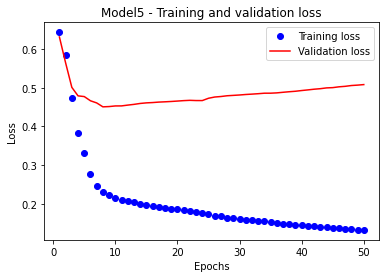

In [89]:
history_dict = history_pad5.history
history_dict.keys()

# Exibindo gráfico de Loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model5 - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

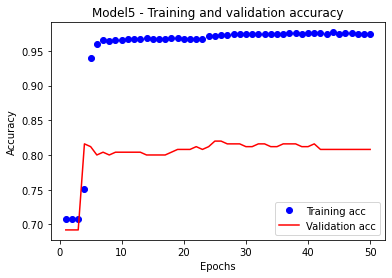

In [90]:
# Exibindo gráfico de Accurácia
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Model5 - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Avaliação de resultados: Teste Bayesiano Hierárquico 

In [91]:
results1
#loss: 0.4462 - accuracy: 0.8204 - auc: 0.8192 - binary_accuracy: 0.8204

[0.4387916624546051,
 0.8421052694320679,
 0.8661991953849792,
 0.8421052694320679]

In [92]:
dict_results = {'modelo1':results1,
               'modelo2':results2,
               'modelo3':results3,
               'modelo4':results4,
               'modelo5':results5}

dict_results

{'modelo1': [0.4387916624546051,
  0.8421052694320679,
  0.8661991953849792,
  0.8421052694320679],
 'modelo2': [0.4812871515750885,
  0.7987616062164307,
  0.8250818252563477,
  0.7987616062164307],
 'modelo3': [0.5607929229736328,
  0.7770897746086121,
  0.7888732552528381,
  0.7770897746086121],
 'modelo4': [0.45797187089920044,
  0.8111454844474792,
  0.8259700536727905,
  0.8111454844474792],
 'modelo5': [0.5083159804344177,
  0.8328173160552979,
  0.7964001893997192,
  0.8328173160552979]}

In [93]:
# criando um data frame para armazenar os resultados do dicionário
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
df_results.reset_index(inplace=True)
df_results.columns=['Modelo', 'Loss', 'Acurácia', 'AUC', 'Acurácia Binária']
df_results = df_results.sort_values(by='Acurácia', ascending=False)
df_results

,Modelo,Loss,Acurácia,AUC,Acurácia Binária
0,modelo1,0.438792,0.842105,0.866199,0.842105
4,modelo5,0.508316,0.832817,0.796400,0.832817
3,modelo4,0.457972,0.811145,0.825970,0.811145
1,modelo2,0.481287,0.798762,0.825082,0.798762
2,modelo3,0.560793,0.777090,0.788873,0.777090


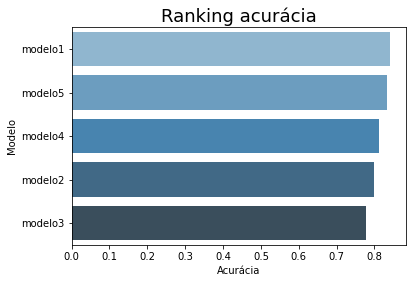

In [94]:
# exibindo o gráfico com a comparação entre acurácia média entre modelos c/ validação cruzada
ax = sns.barplot(x=df_results["Acurácia"], y="Modelo", data=df_results,
                 palette="Blues_d")
ax.set_title('Ranking acurácia', fontsize=18);


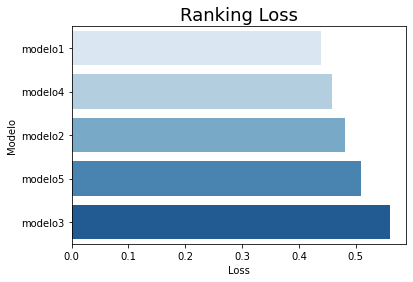

In [95]:
# exibindo o gráfico com a comparação entre acurácia média entre modelos c/ validação cruzada
df_results = df_results.sort_values(by='Loss')
ax = sns.barplot(x=df_results["Loss"], y="Modelo", data=df_results,
                 palette="Blues")
ax.set_title('Ranking Loss', fontsize=18);